In [2]:
import os
import math
import shutil
import numpy as np
import pandas as pd

from pathlib import Path
from tqdm.notebook import tqdm, trange

import cmaps
import cartopy.crs as ccrs
import cartopy.feature as cfeature

import cmaps
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.colors as mcolors
from matplotlib.ticker import NullFormatter, FixedLocator, FormatStrFormatter, MultipleLocator, PercentFormatter, FuncFormatter
import matplotlib.ticker as mticker

import xarray as xr


In [3]:
version = "daily_100"

In [4]:
Merge_data_path = Path("/data6t/AIWP_TP_dataset/merge_data")
Merge_daily_data_path = Merge_data_path / "daily"

Durre_data_path = Path("/data6t/AIWP_TP_dataset/Durre2010_data")
Durre_daily_data_path = Durre_data_path / "daily"

Hamada_data_path = Path("/data6t/AIWP_TP_dataset/Hamada2011_data")
Hamada_daily_data_path = Hamada_data_path / "daily"

Beck_data_path = Path("/data6t/AIWP_TP_dataset/Beck2019_data")
Beck_daily_data_path = Beck_data_path / "daily"

QC_data_path = Path("/data6t/AIWP_TP_dataset/QC_data")
QC_daily_data_path = QC_data_path / "daily"

In [5]:
station_info_df = pd.read_csv(QC_data_path / f"{version}_station_info_2025.csv")
station_info_df

ID  LATITUDE  LONGITUDE  ELEVATION  FREQUENCY  \
0      GHCNh_ACW00011647  17.13330  298.21670       19.2          6   
1      GHCNh_AGI0000DAAT  22.81150    5.45110     1377.1          3   
2      GHCNh_AGI0000DAOH  34.82000  358.23000      426.0         24   
3      GHCNh_AGM00060353  36.81670    5.88330        6.0          6   
4      GHCNh_AGM00060395  36.70000    4.13330      153.0         24   
...                  ...       ...        ...        ...        ...   
58791   GSOD_A0000253928  30.21889  263.62583       93.9         24   
58792   GSOD_A0000594076  40.05361  253.63111     2258.9         24   
58793   GSOD_A0002453848  30.51195  273.04594       34.0         24   
58794   GSOD_A0003225715  52.22028  185.79389       17.1         24   
58795   GSOD_A0573500209  33.60000  262.21700      336.2         24   

       best_shift_hour  reporting_time  year_length  
0                  4.0            -4.0     4.750685  
1                 48.0           -48.0     0.865753  
2                  5.0            -5.0     5.232877  
3                  2.0            -2.0     0.802740  
4                  7.0            -7.0     5.254795  
...                ...             ...          ...  
58791            -17.0            17.0     3.290411  
58792            -15.0            15.0     3.306849  
58793            -17.0            17.0     4.465753  
58794            -14.0            14.0     2.232877  
58795            -18.0            18.0     5.493151  

[58796 rows x 8 columns]

In [ ]:
lat = np.linspace(90, -90, 91) 
lon = np.linspace(0, 360, 181)[:180]

station_info_df['LAT_INDEX'] = station_info_df['LATITUDE'].apply(lambda x: np.abs(lat - x).argmin())
station_info_df['LON_INDEX'] = station_info_df['LONGITUDE'].apply(lambda x: np.abs(lon - x).argmin())

# grid_to_id_mapping = filtered_stations.groupby(['LAT_INDEX', 'LON_INDEX'])['ID'].apply(list).to_dict()
grid_to_id_mapping = station_info_df.groupby(['LAT_INDEX', 'LON_INDEX'])['ELEVATION'].apply(list).to_dict()

# Create a mask DataArray with the same lat and lon dimensions
station_num = xr.DataArray(
    data=np.zeros((len(lat), len(lon)), dtype=int),  # Initialize with False
    coords={"lat": lat, "lon": lon},
    dims=["lat", "lon"],
    name="station_num"
)
mean_elevation = xr.DataArray(
    data=np.zeros((len(lat), len(lon)), dtype=int)*np.nan,  # Initialize with False
    coords={"lat": lat, "lon": lon},
    dims=["lat", "lon"],
    name="mean_elevation"
)

# Set mask values to True for grid cells with station data
for (lat_index, lon_index), station_ids in grid_to_id_mapping.items():
    station_num[lat_index, lon_index] = len(station_ids)
    mean_elevation[lat_index, lon_index] = np.mean(station_ids)

xr.Dataset({"station_num": station_num, "mean_elevation": mean_elevation})

<xarray.Dataset> Size: 264kB
Dimensions:         (lat: 91, lon: 180)
Coordinates:
  * lat             (lat) float64 728B 90.0 88.0 86.0 84.0 ... -86.0 -88.0 -90.0
  * lon             (lon) float64 1kB 0.0 2.0 4.0 6.0 ... 354.0 356.0 358.0
Data variables:
    station_num     (lat, lon) int64 131kB 9 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0
    mean_elevation  (lat, lon) float64 131kB nan nan nan nan ... nan nan nan nan

# Fig.2

In [18]:
station_info_df["SOURCE"] = station_info_df["ID"].apply(lambda x: x.split("_")[0])
station_info_df

ID  LATITUDE  LONGITUDE  ELEVATION  FREQUENCY  \
0      GHCNh_ACW00011647  17.13330  298.21670       19.2          6   
1      GHCNh_AGI0000DAAT  22.81150    5.45110     1377.1          3   
2      GHCNh_AGI0000DAOH  34.82000  358.23000      426.0         24   
3      GHCNh_AGM00060353  36.81670    5.88330        6.0          6   
4      GHCNh_AGM00060395  36.70000    4.13330      153.0         24   
...                  ...       ...        ...        ...        ...   
58791   GSOD_A0000253928  30.21889  263.62583       93.9         24   
58792   GSOD_A0000594076  40.05361  253.63111     2258.9         24   
58793   GSOD_A0002453848  30.51195  273.04594       34.0         24   
58794   GSOD_A0003225715  52.22028  185.79389       17.1         24   
58795   GSOD_A0573500209  33.60000  262.21700      336.2         24   

       best_shift_hour  reporting_time  year_length  LAT_INDEX  LON_INDEX  \
0                  4.0            -4.0     4.750685         36        149   
1                 48.0           -48.0     0.865753         34          3   
2                  5.0            -5.0     5.232877         28        179   
3                  2.0            -2.0     0.802740         27          3   
4                  7.0            -7.0     5.254795         27          2   
...                ...             ...          ...        ...        ...   
58791            -17.0            17.0     3.290411         30        132   
58792            -15.0            15.0     3.306849         25        127   
58793            -17.0            17.0     4.465753         30        137   
58794            -14.0            14.0     2.232877         19         93   
58795            -18.0            18.0     5.493151         28        131   

      SOURCE  
0      GHCNh  
1      GHCNh  
2      GHCNh  
3      GHCNh  
4      GHCNh  
...      ...  
58791   GSOD  
58792   GSOD  
58793   GSOD  
58794   GSOD  
58795   GSOD  

[58796 rows x 11 columns]

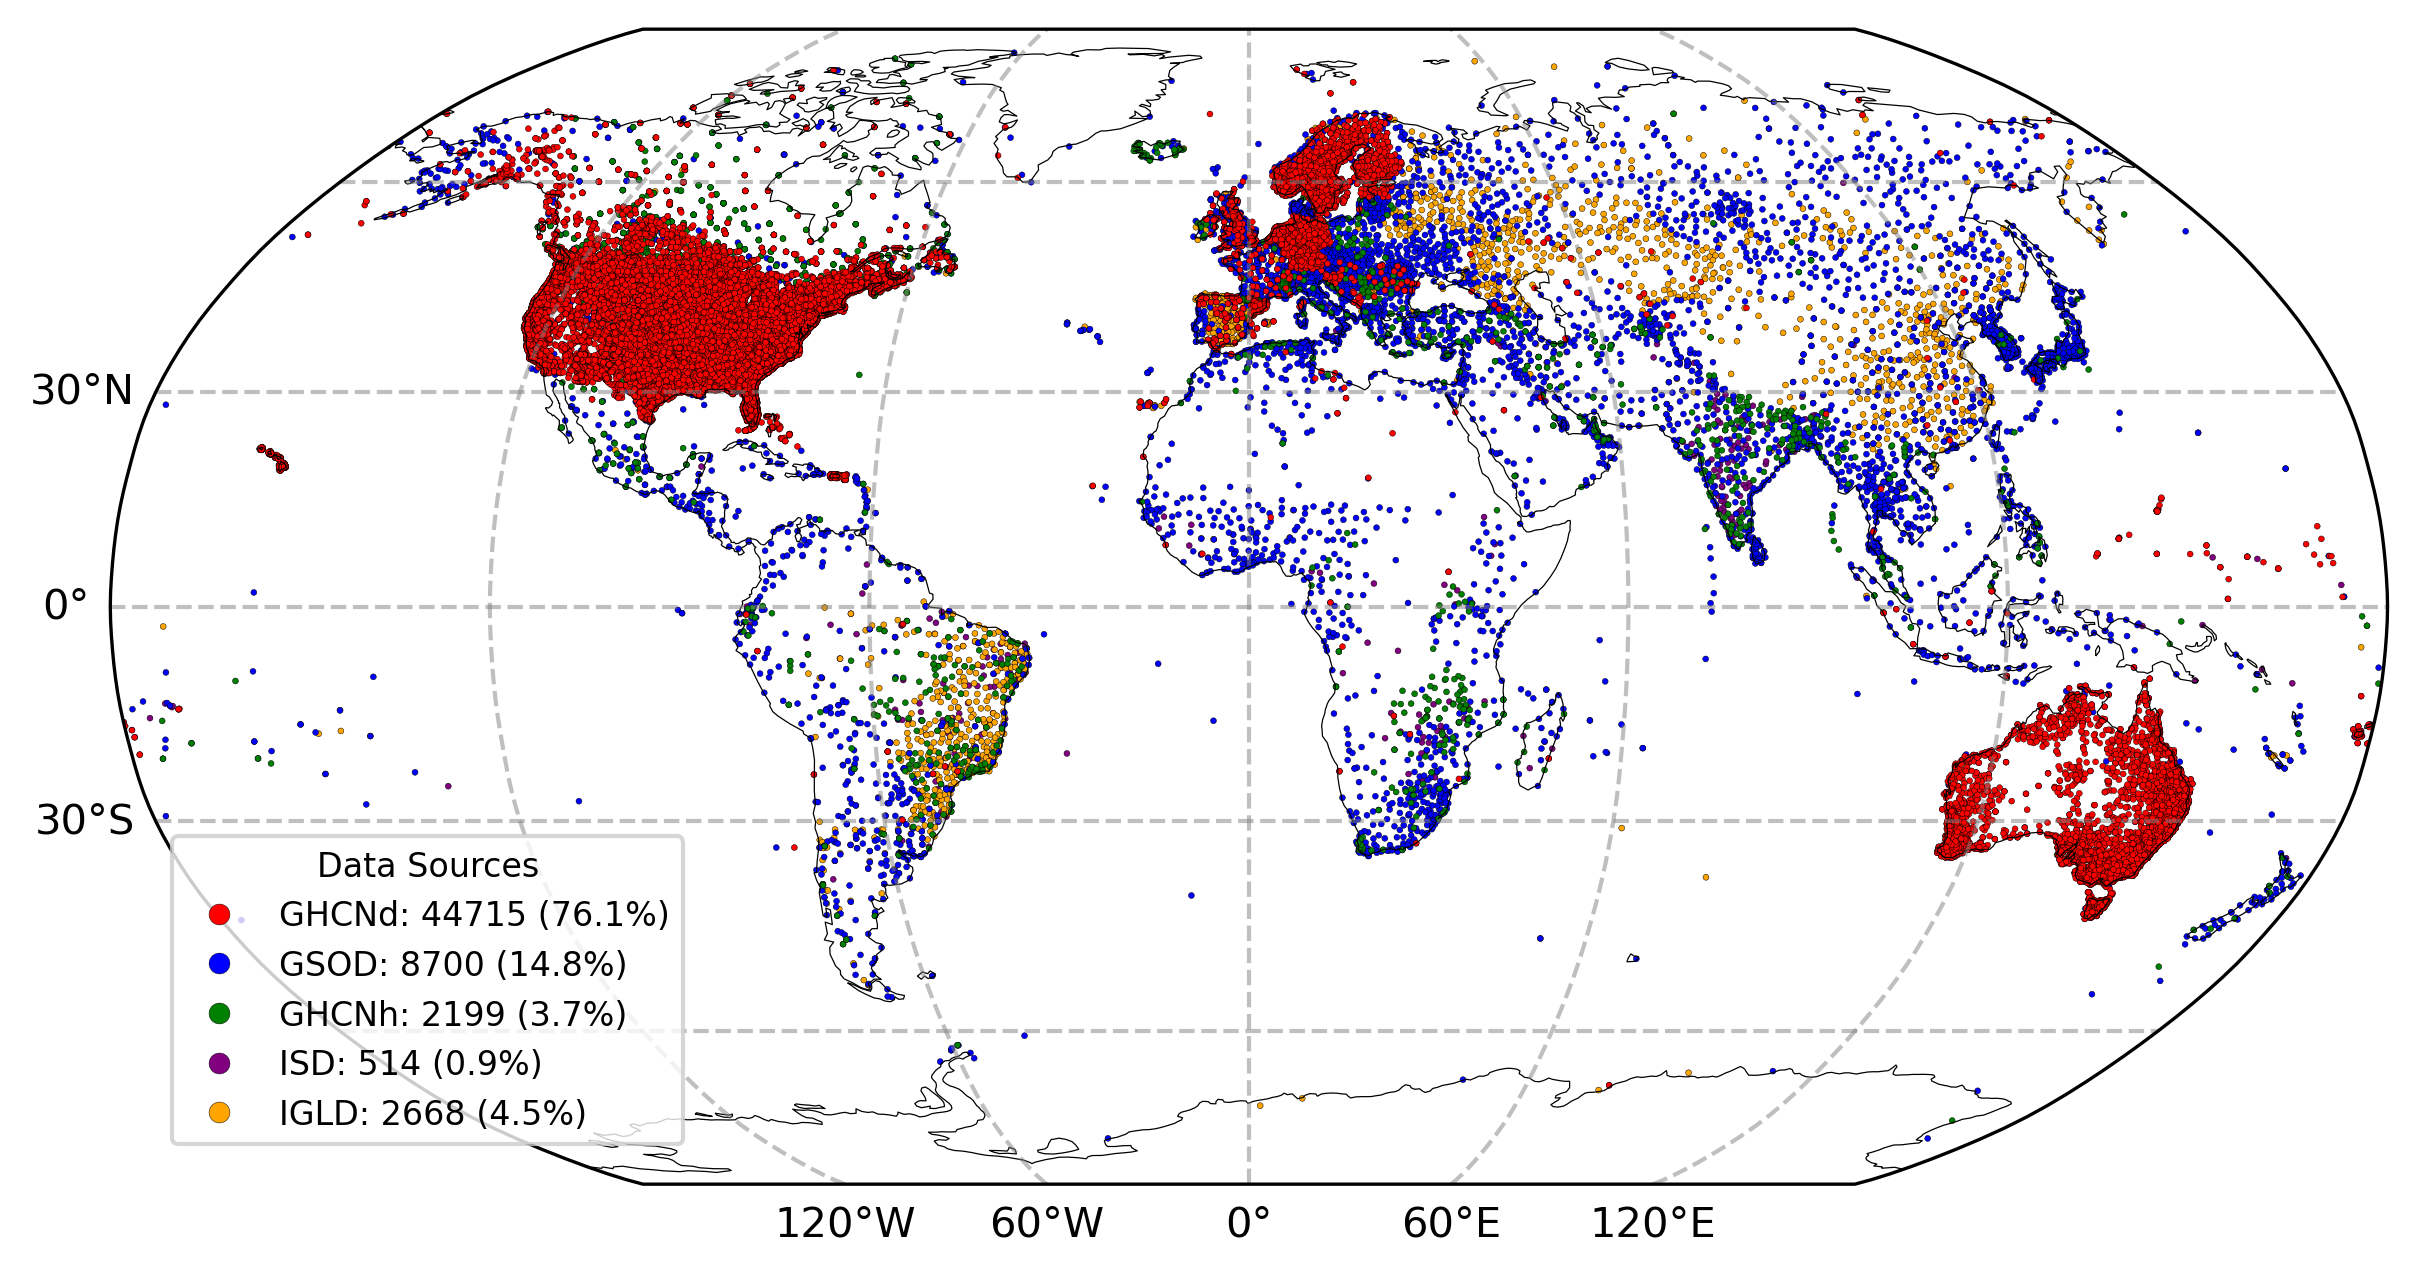

In [20]:
fig = plt.figure(figsize=(10, 5), dpi=300)
lon_center = 0
map_proj = ccrs.Robinson(central_longitude=lon_center)
# map_proj = ccrs.PlateCarree(central_longitude=lon_center)

data_proj = ccrs.PlateCarree()
ax = fig.add_subplot(1, 1, 1, projection=map_proj)
ax.coastlines(linewidth=0.3)
ax.set_global()

data = station_info_df.sort_values("SOURCE", ascending=False)
# data = data[data["SOURCE"].isin(["GHCNd", "GSOD"])] # , "GHCNh", "ISD", "IGLD"
scatter = sns.scatterplot(data=data, x="LONGITUDE", y="LATITUDE", hue="SOURCE", 
                          palette={"GHCNd": "red", "GSOD":"blue", "GHCNh": "green", 
                                   "ISD": "purple", "IGLD": "orange"}, 
                        #   palette={"GHCNd": "orange", "GSOD":"blue", "GHCNh": "green", 
                        #            "ISD": "purple", "IGLD": "red"},
                        hue_order=["GHCNd", "GSOD", "GHCNh", "ISD", "IGLD"], 
                          ax=ax, transform=data_proj, **{"s": 2, "edgecolor": 'k', "alpha": 1})

handles, labels = ax.get_legend_handles_labels()
for label in labels:
    # 对齐计数和百分比
    labels[labels.index(label)] = label + f": {(station_info_df['SOURCE']==label).sum()} ({(station_info_df['SOURCE']==label).sum()/len(station_info_df)*100:.1f}%)"
ax.legend(handles=handles, labels=labels, title="Data Sources", fontsize=fs-2, title_fontsize=fs-2,
          loc='lower left', bbox_to_anchor=(0.02, 0.02))
for handle in ax.get_legend().legend_handles:
    handle.set_markersize(5)
# data = station_info_df[station_info_df["ID"].isin(station_id_list)]

# pcm = ax.scatter(data["LONGITUDE"].values, data["LATITUDE"].values, 
#                     # c=data.values, 
#                     s=1, edgecolor='None',color='blue',
#                     transform=data_proj,
#                     # cmap=cmap, norm=norm,
#                     # cmap=cmaps.MPL_winter_r, vmin=0, vmax=10,
#                     )
gl = ax.gridlines(draw_labels=False, linewidth=1, color='gray', alpha=0.5, linestyle='--')
# gl.ylocator = mticker.FixedLocator([-90, -60, -30, 0, 30, 60, 90])
gl.xlocator = mticker.FixedLocator([-120, -60, 0, 60, 120])
gl.left_labels = True
gl.bottom_labels = True

fig.savefig("figures/Figure 2.jpg", dpi=300, bbox_inches="tight")



# Fig.8

In [21]:
MSWEP_results = pd.read_csv("Corr_raw_qc_mswep_2025.csv").rename(columns={"station": "ID"})
IMERG_results = pd.read_csv("Corr_raw_qc_imerg_2025.csv").rename(columns={"station": "ID"})
ERA5_results = pd.read_csv("Corr_raw_qc_era5_2025.csv").rename(columns={"station": "ID"})
# GPCC_results = pd.read_csv("Corr_raw_qc_gpcc_2025.csv").rename(columns={"station": "ID"})
MSWEP_results

ID  qc_pearson  raw_pearson  qc_spearman  raw_spearman
0      GHCNd_US1Boyd4042    0.622711     0.622711     0.396043      0.396043
1      GHCNd_US1MIGN0042    0.491770     0.491770     0.392618      0.392618
2      GHCNd_US1TXGP0123    0.644076     0.644076     0.488799      0.488799
3      GHCNd_US1MSJC0035    0.720555     0.720555     0.553963      0.553963
4      GHCNd_ASN00014259    0.281550     0.281550     0.304608      0.304608
...                  ...         ...          ...          ...           ...
58003  GHCNd_CA002503648    0.767275     0.767190     0.584041      0.584594
58004   GSOD_24538099999    0.336998     0.336998     0.485523      0.485523
58005   GSOD_24639099999    0.374611     0.394443     0.513013      0.513650
58006   GSOD_41055099999    0.363473     0.363473     0.316737      0.316737
58007   GSOD_87938099999    0.369938     0.300958     0.321296      0.321062

[58008 rows x 5 columns]

-0.6814500799751284


/tmp/ipykernel_61962/3347806923.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="shifthour", y="raw_pearson", data=plot_data, ax=ax, palette=cmaps.MPL_Blues.colors[20:],
/tmp/ipykernel_61962/3347806923.py:38: UserWarning: The palette list has more values (108) than needed (49), which may not be intended.
  sns.boxplot(x="shifthour", y="raw_pearson", data=plot_data, ax=ax, palette=cmaps.MPL_Blues.colors[20:],


-0.6960564880436009


/tmp/ipykernel_61962/3347806923.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="shifthour", y="raw_pearson", data=plot_data, ax=ax, palette=cmaps.MPL_Blues.colors[20:],
/tmp/ipykernel_61962/3347806923.py:38: UserWarning: The palette list has more values (108) than needed (49), which may not be intended.
  sns.boxplot(x="shifthour", y="raw_pearson", data=plot_data, ax=ax, palette=cmaps.MPL_Blues.colors[20:],


-0.6732963539705342


/tmp/ipykernel_61962/3347806923.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="shifthour", y="raw_pearson", data=plot_data, ax=ax, palette=cmaps.MPL_Blues.colors[20:],
/tmp/ipykernel_61962/3347806923.py:38: UserWarning: The palette list has more values (108) than needed (49), which may not be intended.
  sns.boxplot(x="shifthour", y="raw_pearson", data=plot_data, ax=ax, palette=cmaps.MPL_Blues.colors[20:],


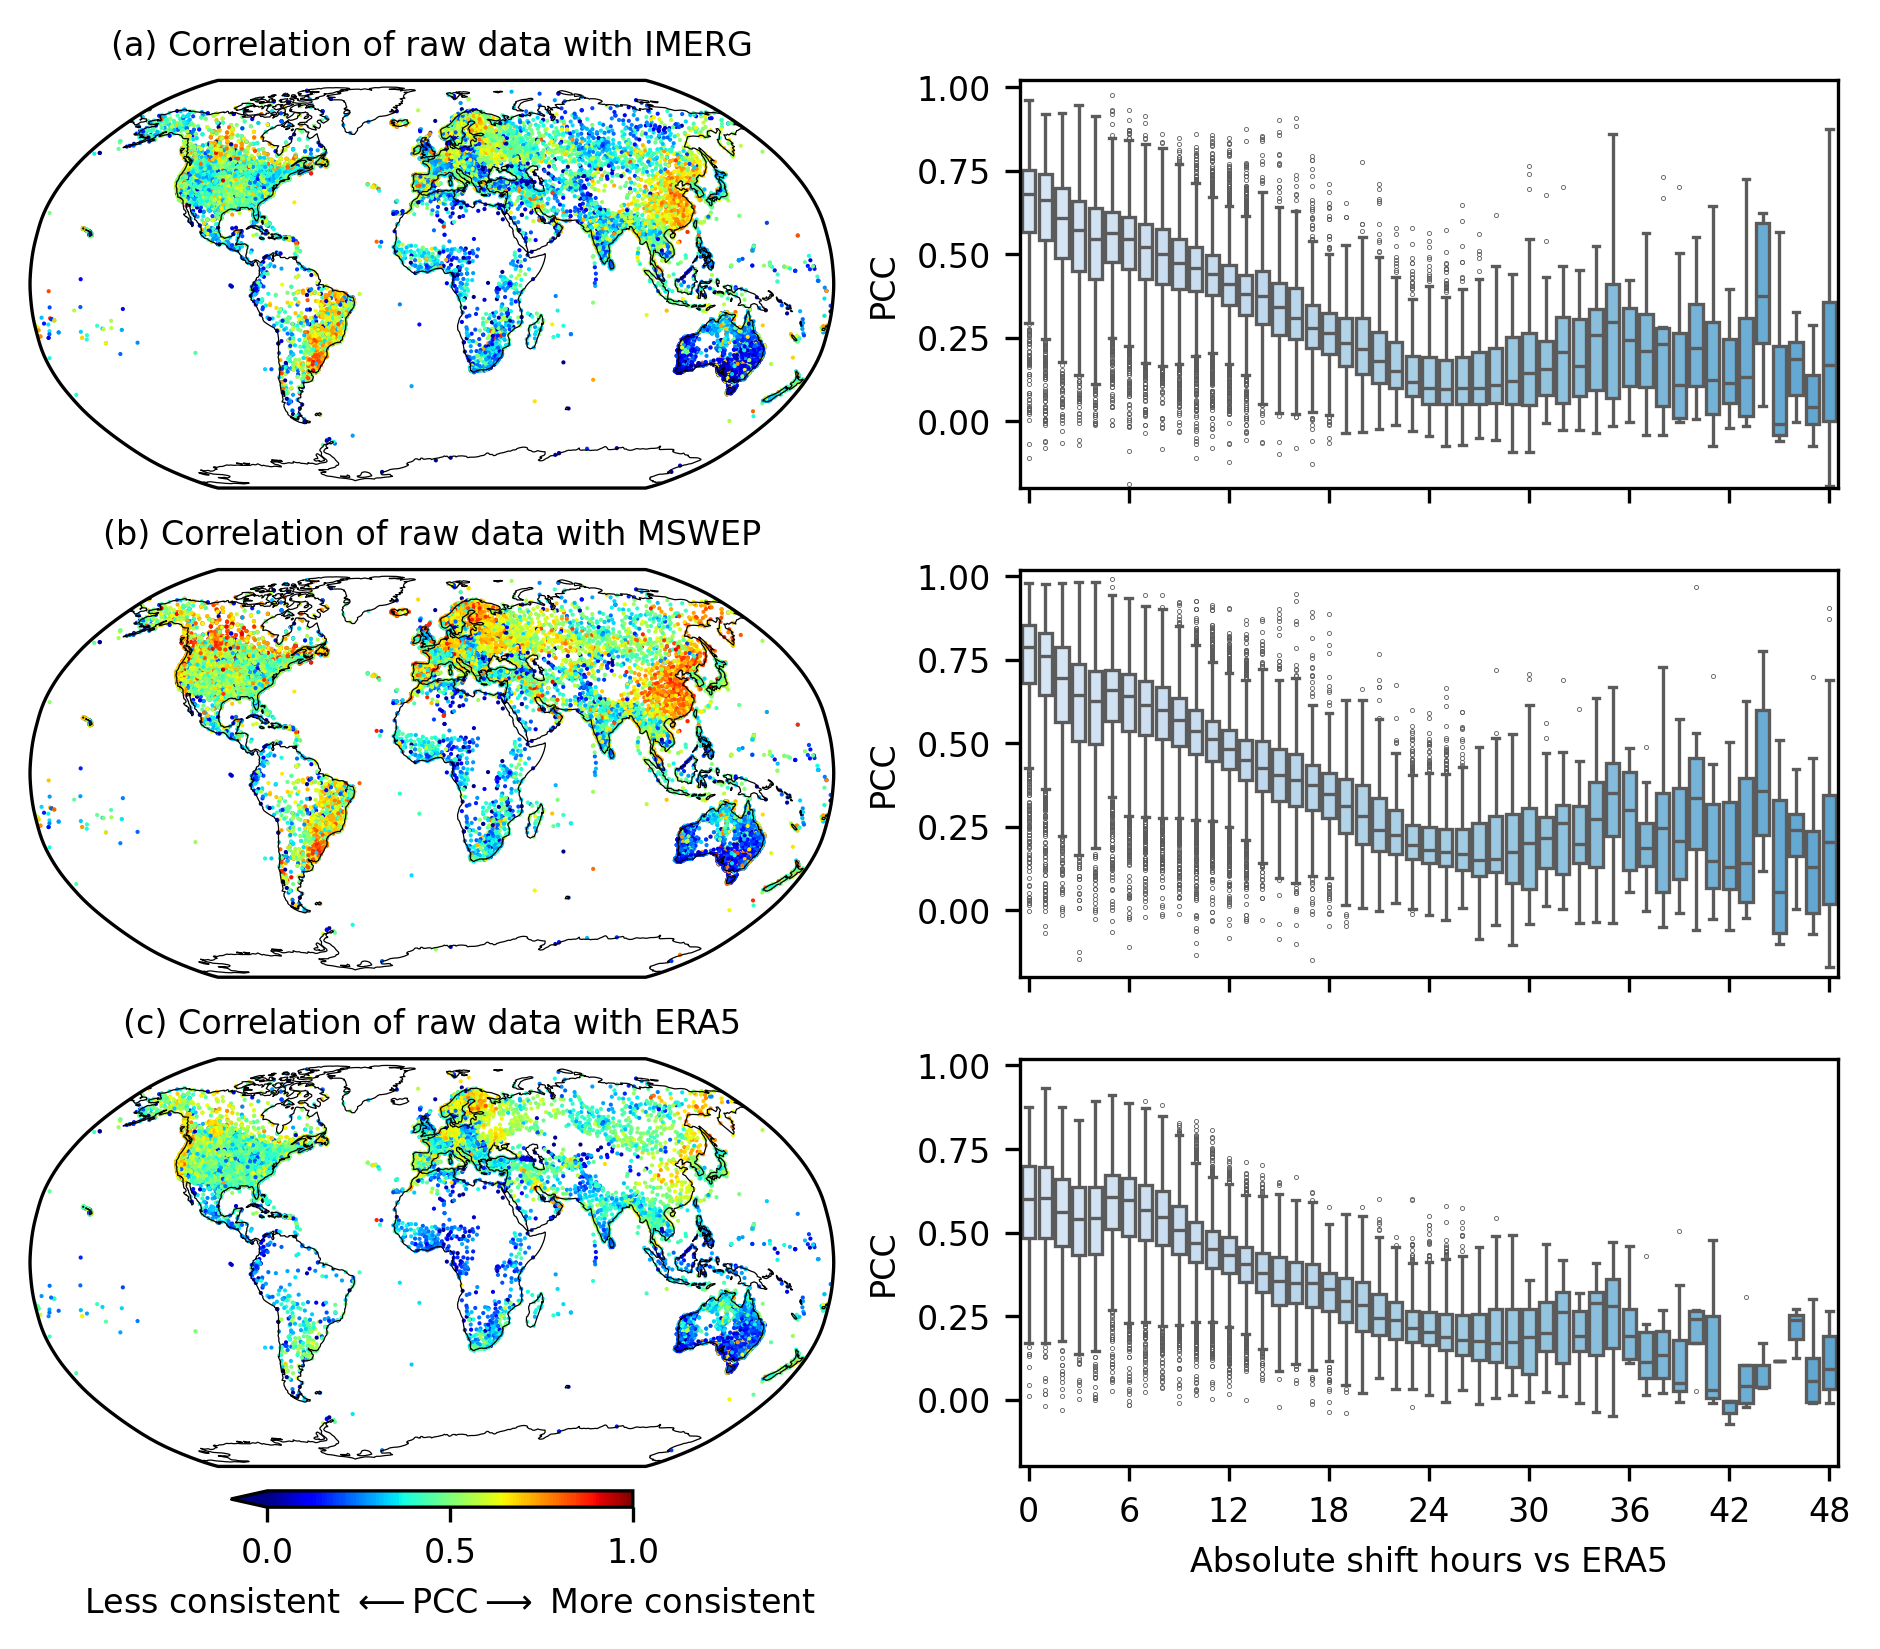

In [22]:
lon_center = 0
fs = 10
map_proj = ccrs.Robinson(central_longitude=lon_center)
# map_proj = ccrs.PlateCarree(central_longitude=lon_center)
data_proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(8, 6), dpi=300)
grids = plt.GridSpec(3, 3, wspace=0.1, hspace=0.2, width_ratios=[1, 0.02, 0.9])

for i, (bench_name, plot_data) in enumerate(
    [("IMERG", IMERG_results.merge(station_info_df, on="ID")),
    ("MSWEP", MSWEP_results.merge(station_info_df, on="ID")),  
    ("ERA5", ERA5_results.merge(station_info_df, on="ID"))]):
    
    ax = fig.add_subplot(grids[i, 0], projection=map_proj)
    ax.set_title(f"({chr(97+i)}) Correlation of raw data with {bench_name}", fontsize=fs-2)
    ax.set_global()
    ax.coastlines(linewidth=0.3)
    # plot_data = plot_data.sort_values("raw_pearson", ascending=False)
    plot = ax.scatter(plot_data["LONGITUDE"], plot_data["LATITUDE"], c=plot_data["raw_pearson"], 
                transform=data_proj, 
                s=1, edgecolor='None', 
                    vmin=0, vmax=1, cmap=cmaps.MPL_jet,
                label='QC Data')
    if i == 2:
        cbar_ax = ax.inset_axes(bounds=[0.25, -0.1, 0.5, 0.04], transform=ax.transAxes)
        cbar = fig.colorbar(plot, cax=cbar_ax, orientation='horizontal', shrink=0.9, pad=.09, 
                            extend="min", extendfrac=0.1)
        cbar.ax.set_xlabel(r"Less consistent $\mathrm{\longleftarrow PCC \longrightarrow}$ More consistent", fontsize=fs-2)
        cbar.ax.set_xticks([0, 0.5, 1.0])
        cbar.ax.tick_params(axis='both', which='major', labelsize=fs-2)

    ax = fig.add_subplot(grids[i, 2])
    plot_data["shifthour"] = np.abs(plot_data["best_shift_hour"])

    print(np.corrcoef(plot_data.dropna()["shifthour"].abs(), plot_data.dropna()["raw_pearson"])[0,1])

    sns.boxplot(x="shifthour", y="raw_pearson", data=plot_data, ax=ax, palette=cmaps.MPL_Blues.colors[20:],
                # legend=False,
                # boxprops=dict(lw=0.8), #medianprops=dict(lw=0.8, color='red'),
                linewidth=0.8, width=0.8, fliersize=0.2,saturation=1,
                # color='lightblue'
                )
    ax.xaxis.set_major_locator(MultipleLocator(6))
    ax.xaxis.set_major_formatter(mticker.StrMethodFormatter('{x:.0f}'))
    ax.set_ylabel("PCC", fontsize=fs-2)
    ax.set_xlabel("Absolute shift hours vs ERA5", fontsize=fs-2) if i == 2 else ax.set_xlabel("")
    ax.set_xticklabels([]) if i != 2 else None
    ax.tick_params(axis='both', which='major', labelsize=fs-2)
    ax.set_ylim(-0.2, 1.02)

fig.savefig("figures/Figure 8.jpg", dpi=300, bbox_inches="tight")


# Fig.9

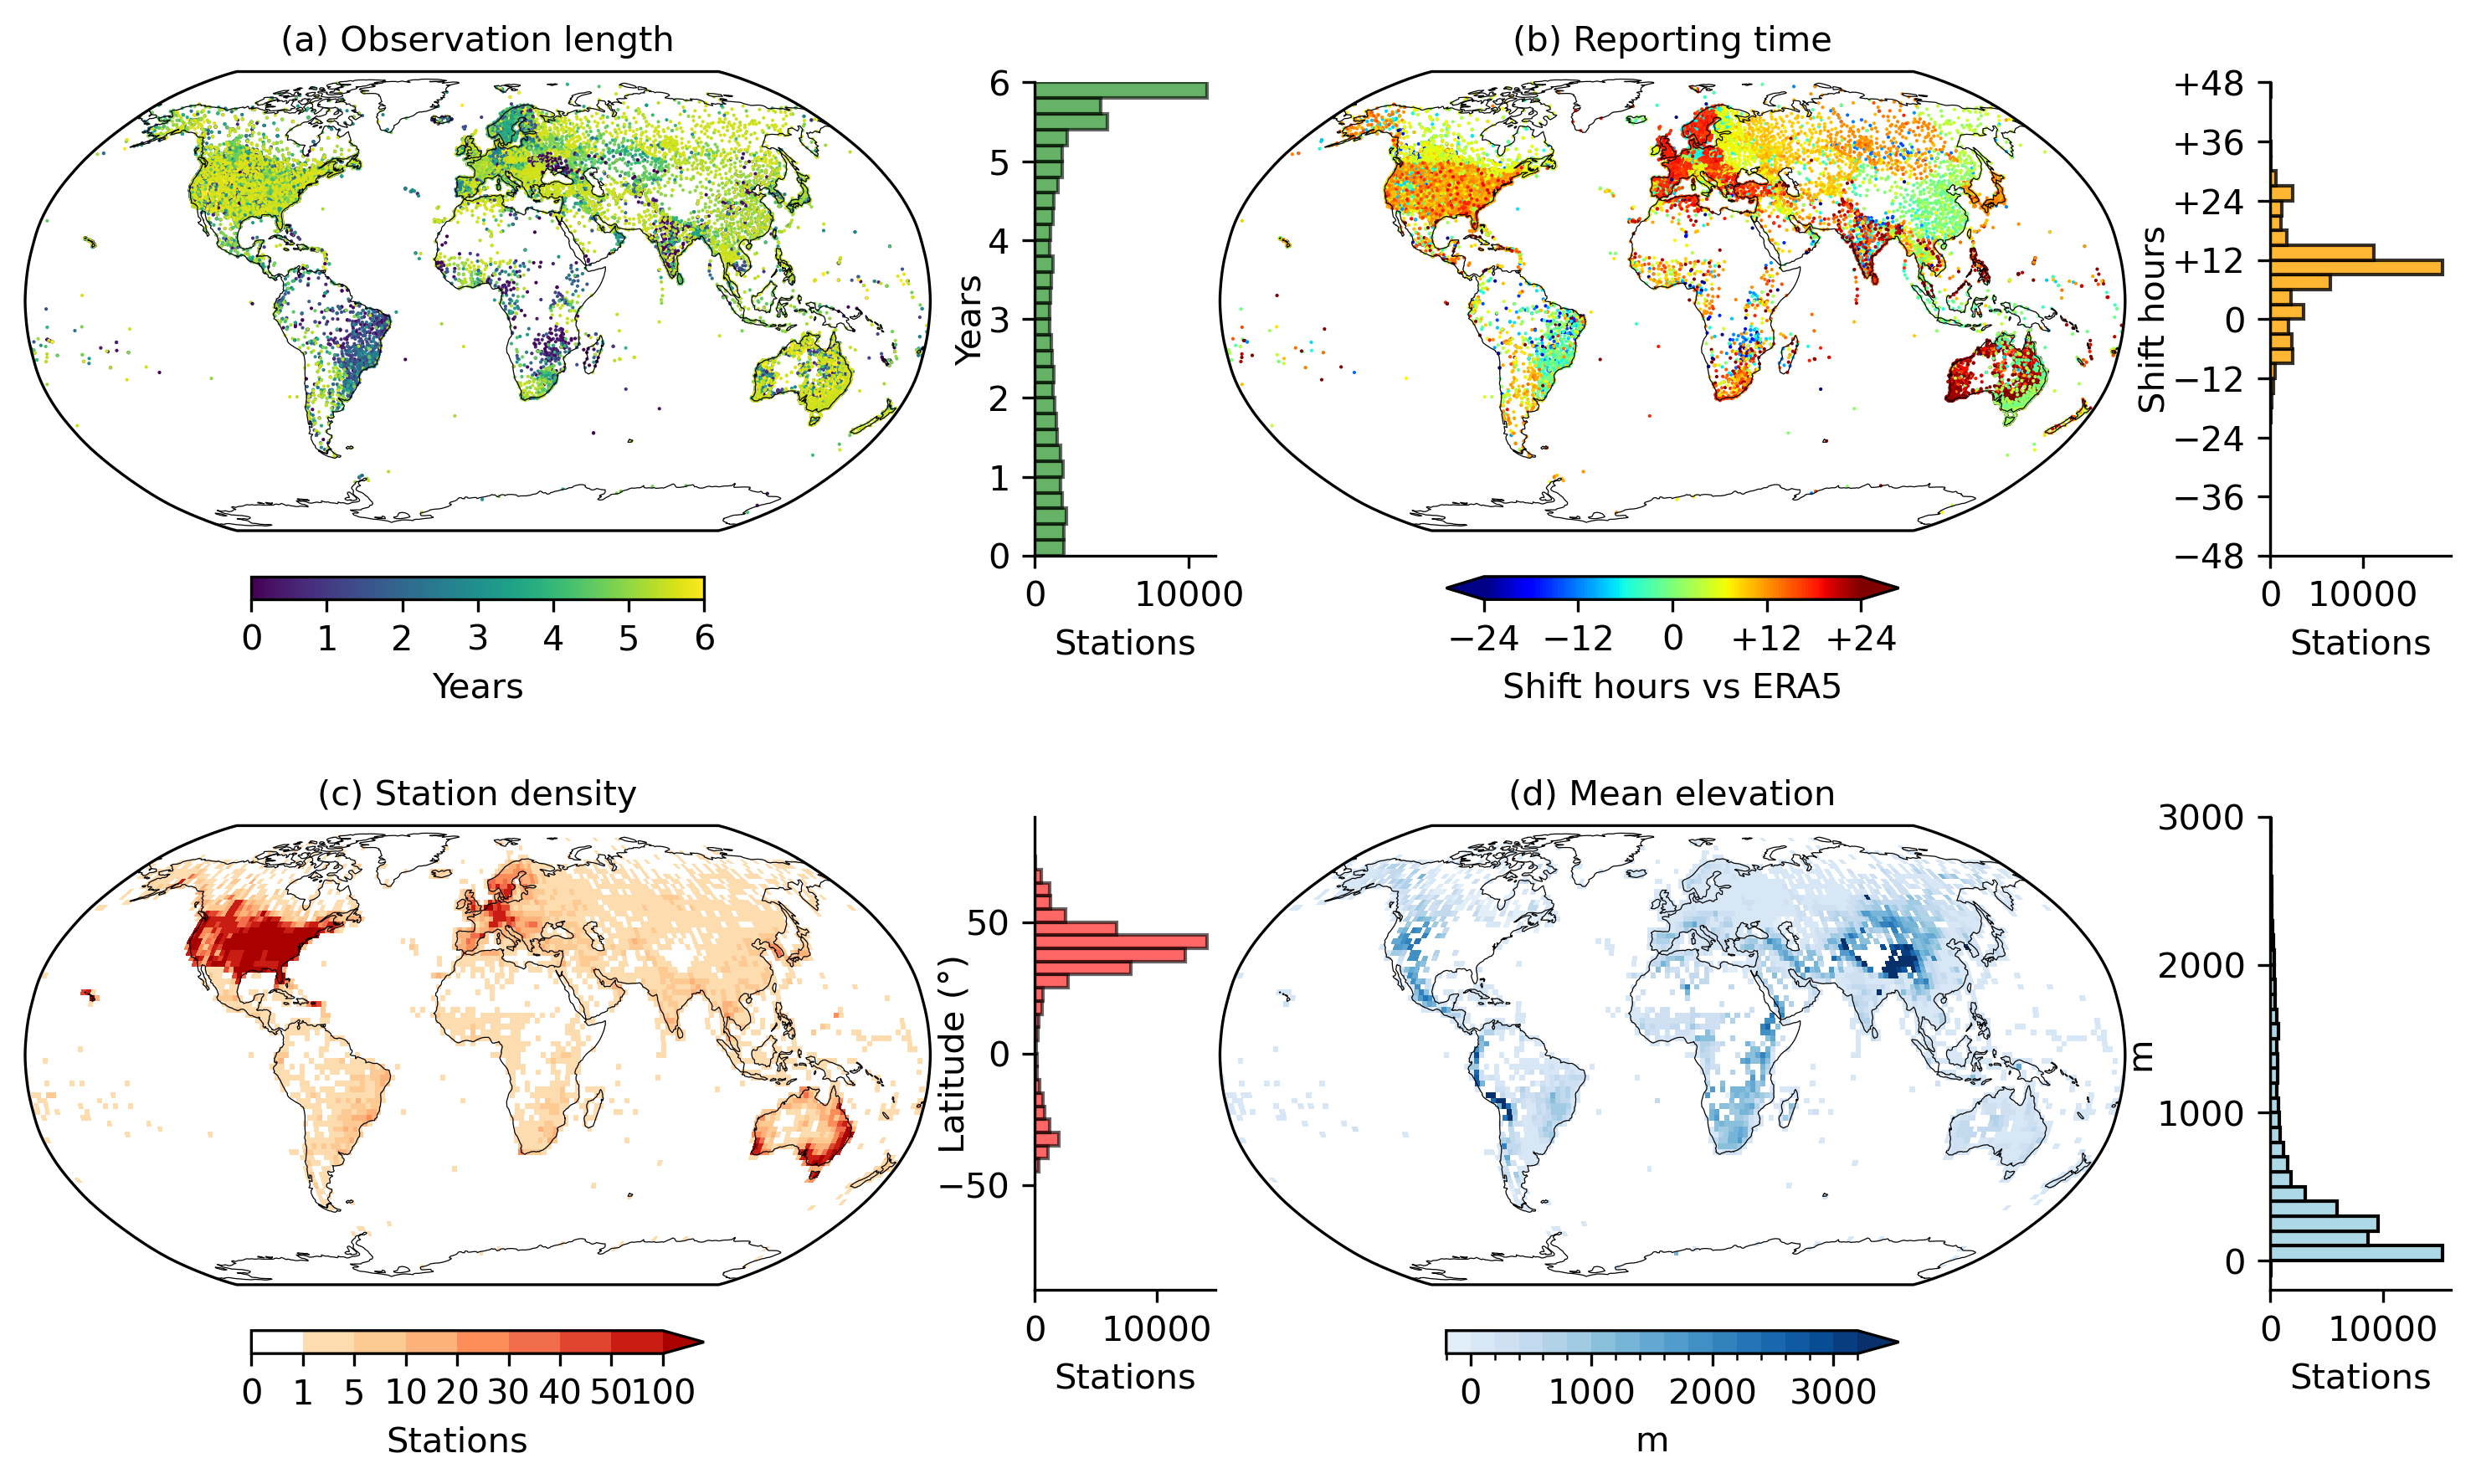

In [ ]:
lon_center = 0
fs = 10
map_proj = ccrs.Robinson(central_longitude=lon_center)
# map_proj = ccrs.PlateCarree(central_longitude=lon_center)
data_proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(12, 6.5), dpi=300)
grids = plt.GridSpec(2, 4, wspace=0.1, hspace=0.5, width_ratios=[1, 0.2, 1, 0.2])

# ------------------(a) Record length--------------
ax = fig.add_subplot(grids[0, 0], projection=map_proj)

ax.coastlines(linewidth=0.3)
ax.set_title("(a) Observation length", fontsize=fs)

# plot_data = raw_station_info_df[~raw_station_info_df["ID"].isin(station_info_df["ID"])]
# pcm = ax.scatter(plot_data["LONGITUDE"].values, plot_data["LATITUDE"].values, 
#                 s=1, edgecolor='None',color='red', transform=data_proj,)

plot_data = station_info_df
plot = ax.scatter(plot_data["LONGITUDE"], plot_data["LATITUDE"], c=plot_data["year_length"], 
                  transform=data_proj, cmap=cmaps.MPL_viridis,
                  s=1, edgecolor='None', vmin=0, vmax=6, label='QC Data')

cbar_ax = ax.inset_axes(bounds=[0.25, -0.15, 0.5, 0.05], transform=ax.transAxes)
cbar = fig.colorbar(plot, cax=cbar_ax, orientation='horizontal', shrink=0.9, pad=.09, 
                    extend=None, extendfrac=0.1)
cbar_ax.set_xlabel('Years', fontsize=fs)
cbar.ax.set_xticks([0, 1, 2, 3, 4, 5, 6])
# cbar_ax.set_ylabel('Years', fontsize=fs, rotation=0, va='center', labelpad=5)


ax = fig.add_subplot(grids[0, 1])
ax.set_position([0.46, 0.57, 0.06, 0.29])  # [left, bottom, width, height]
# ax.set_title("(d) Statistical distribution", fontsize=fs)

plot_data = station_info_df["year_length"]
bins = np.arange(0, 6.1, 0.2)
# bins = np.arange(0, 1.01, 0.05)
ax.hist(plot_data.values.clip(0, 6), bins=bins, density=False, alpha=0.6, orientation='horizontal', edgecolor='black', color='Green')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylim(0, 6)
ax.set_ylabel("Years", fontsize=fs, labelpad=0)
ax.set_xlabel("Stations", fontsize=fs)


# ------------------(b) reporting_time--------------
ax = fig.add_subplot(grids[0, 2], projection=map_proj)
ax.coastlines(linewidth=0.3)
ax.set_title("(b) Reporting time", fontsize=fs)

plot_data = station_info_df
plot = ax.scatter(plot_data["LONGITUDE"], plot_data["LATITUDE"], c=plot_data["reporting_time"], transform=data_proj, 
                  s=1, edgecolor='None', 
                #   cmap=my_cmap2, norm=my_norm2,
                  cmap=cmaps.MPL_jet, vmin=-24, vmax=24, 
                  label='QC Data') # circular_1 circular_2 MPL_jet_r
 
cbar_ax = ax.inset_axes(bounds=[0.25, -0.15, 0.5, 0.05], transform=ax.transAxes)
cbar = fig.colorbar(plot, cax=cbar_ax, orientation='horizontal', shrink=0.9, pad=.09, 
                    extend="both", extendfrac=0.1)
# cbar_ax.set_xlabel('Shift hours', fontsize=fs)
cbar.ax.set_xlabel("Shift hours vs ERA5", fontsize=fs)
cbar.ax.set_xticks([-24, -12, 0, 12, 24])
cbar.ax.xaxis.set_major_formatter(mticker.FuncFormatter(
    lambda x, pos: '0' if abs(x) < 1e-10 else f'{x:+.0f}'.replace('-', '\u2212')))
ax = fig.add_subplot(grids[0, 3])
ax.set_position([0.87, 0.57, 0.06, 0.29])  # [left, bottom, width, height]

bins = np.arange(-48, 49, 3)
plot_data = station_info_df["reporting_time"] # reporting_time; best_shift_hour + 24
# ax.hist(plot_data.values, bins=bins, density=False, alpha=0.6, orientation='horizontal', edgecolor='black',color='blue')
ax.hist(plot_data.values, bins=bins, density=False, alpha=0.8, orientation='horizontal', edgecolor='black',color='orange')
ax.yaxis.set_major_locator(MultipleLocator(12))
# ax.yaxis.set_major_formatter(mticker.StrMethodFormatter('{x:+.0f}'))
ax.yaxis.set_major_formatter(mticker.FuncFormatter(
    lambda x, pos: '0' if abs(x) < 1e-10 else f'{x:+.0f}'.replace('-', '\u2212')))

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylim(-48, 48)
ax.set_ylabel("Shift hours", fontsize=fs, labelpad=0)
ax.set_xlabel("Stations", fontsize=fs)


# ------------------(c) Station density--------------
ax = fig.add_subplot(grids[1, 0], projection=map_proj)
ax.coastlines(linewidth=0.3)
ax.set_title("(c) Station density", fontsize=fs)

plot_data = station_num
pcm = ax.pcolormesh(plot_data["lon"].values, plot_data["lat"].values, 
                    plot_data.values, transform=ccrs.PlateCarree(),
                    cmap=my_cmap, norm=my_norm,)
cbar_ax = ax.inset_axes(bounds=[0.25, -0.15, 0.5, 0.05], transform=ax.transAxes)
cbar = fig.colorbar(pcm, cax=cbar_ax, orientation='horizontal', shrink=0.9, pad=.09, 
                    extend="max", extendfrac=0.1)
cbar_ax.set_xlabel('Stations', fontsize=fs)

ax = fig.add_subplot(grids[1, 1])
ax.set_position([0.46, 0.12, 0.06, 0.29])  # [left, bottom, width, height]
bins = np.arange(-90, 91, 5)
plot_data = station_info_df["LATITUDE"]
ax.hist(plot_data.values, bins=bins, density=False, alpha=0.6, orientation='horizontal', edgecolor='black',color='red')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylim(-90, 90)
ax.set_ylabel("Latitude (°)", fontsize=fs, labelpad=-10)
ax.set_xlabel("Stations", fontsize=fs)


# ------------------(d)  Mean elevation--------------
ax = fig.add_subplot(grids[1, 2], projection=map_proj)
ax.coastlines(linewidth=0.3)
ax.set_title("(d) Mean elevation", fontsize=fs)

plot_data = mean_elevation
pcm = ax.pcolormesh(plot_data["lon"].values, plot_data["lat"].values, 
                    plot_data.values, transform=ccrs.PlateCarree(),
                    # cmap="Blues", vmin=-400, vmax=3000,
                    cmap=my_cmap3, norm=my_norm3,
                    )

cbar_ax = ax.inset_axes(bounds=[0.25, -0.15, 0.5, 0.05], transform=ax.transAxes)
cbar = fig.colorbar(pcm, cax=cbar_ax, orientation='horizontal', shrink=0.9, pad=.09, 
                    extend="max", extendfrac=0.1)
cbar.ax.set_xticks([0, 1000, 2000, 3000])
cbar_ax.set_xlabel('m', fontsize=fs)


ax = fig.add_subplot(grids[1, 3])
ax.set_position([0.87, 0.12, 0.06, 0.29])  # [left, bottom, width, height]
bins = np.arange(-200, 3001, 100)
plot_data = station_info_df["ELEVATION"]
ax.hist(plot_data.values, bins=bins, density=False, alpha=1, orientation='horizontal', edgecolor='black',color='lightblue')
# ax.set_xlabel("Elevation (m)", fontsize=10)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylim(-200, 3000)
ax.set_ylabel("m", fontsize=fs, labelpad=0)
ax.set_xlabel("Stations", fontsize=fs)

fig.savefig("figures/Figure 9.jpg", dpi=300, bbox_inches="tight")
